In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, COMMON_STAGES, SAT_CLASSES_ACCURACY
from hmpai.visualization import *
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import pandas as pd
from hmpai.behaviour.sat2 import read_behavioural_info
DATA_PATH = Path(os.getenv("DATA_PATH"))

from rpy2.robjects import conversion, default_converter
from sklearn.preprocessing import StandardScaler
from pymer4.models import Lmer
import warnings


### Load data

In [2]:
torch.cuda.empty_cache()
torch.set_grad_enabled(False)

In [3]:
set_global_seed(42)
data_path_sat2 = DATA_PATH / "sat2/stage_data_100hz.nc"
dataset_sat2 = xr.load_dataset(data_path_sat2)
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")

In [4]:
dataset_sat2

<xarray.Dataset> Size: 3GB
Dimensions:      (epochs: 2447, channels: 30, samples: 250, participant: 18)
Coordinates:
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 244 245 246 247 248 249
  * participant  (participant) <U3 216B 'S10' 'S11' 'S12' ... 'S7' 'S8' 'S9'
    event_name   (participant, epochs) <U21 4MB 'low/accuracy/right/3' ... 'a...
    rt           (participant, epochs) float64 352kB 0.7334 0.5977 ... 1.014
Data variables:
    data         (participant, epochs, channels, samples) float64 3GB 1.256e-...
    labels       (participant, epochs, samples) <U13 573MB 'pre-attentive' .....
Attributes:
    sfreq:           102.4
    offset:          0
    lowpass:         33.03225806451613
    highpass:        1.0
    lower_limit_RT:  0.25
    upper_limit_RT:  2.5

In [5]:
# XArray dimensions to keep in batching (used to find which trial was used)
info_to_keep = ["rt", "participant", "epochs"]
# Does not remove epochs since sp/ac epoch differ per participant so no epoch is fully sp/ac
shape_topological = False
_, _, test_data_sat2 = split_data_on_participants(dataset_sat2, 60, norm_min1_to_1)
test_data_sat2_sp = test_data_sat2.where(
    test_data_sat2.event_name.str.contains("speed"), drop=True
)
test_data_sat2_acc = test_data_sat2.where(
    test_data_sat2.event_name.str.contains("accuracy"), drop=True
)

test_dataset_sp = SAT1Dataset(
    test_data_sat2_sp,
    shape_topological=shape_topological,
    labels=SAT_CLASSES_ACCURACY,
    set_to_zero=True,
    info_to_keep=info_to_keep,
)
test_dataset_acc = SAT1Dataset(
    test_data_sat2_acc,
    shape_topological=shape_topological,
    labels=SAT_CLASSES_ACCURACY,
    set_to_zero=True,
    info_to_keep=info_to_keep,
)

test_loader_sp = DataLoader(
    test_dataset_sp, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)
test_loader_acc = DataLoader(
    test_dataset_acc, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)

### Load model

In [6]:
chk_path = Path("../models/sat2_transformer_100hz_sequence_b2b.pt")
checkpoint = load_model(chk_path)
model_kwargs = {
    "d_model": len(test_data_sat2.channels),
    "num_heads": 10,
    "ff_dim": 2048,
    "num_layers": 6,
    "num_classes": len(SAT_CLASSES_ACCURACY),
}
model = Seq2SeqTransformer(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Apply model

In [7]:
data_sp = predict_with_auc(model, test_loader_sp, info_to_keep, SAT_CLASSES_ACCURACY)
data_acc = predict_with_auc(model, test_loader_acc, info_to_keep, SAT_CLASSES_ACCURACY)
data = pd.concat([data_sp, data_acc])
data = data.merge(
    behaviour_sat2, left_on=["participant", "epochs"], right_on=["participant", "trial"]
)

In [8]:
data

,rt_x,participant,epochs,negative_pred_samples,encoding_pred_samples,decision_pred_samples,confirmation_pred_samples,response_pred_samples,negative_true_samples,encoding_true_samples,...,contrast,N200,trial,givenResp,response,rt_y,prmt,mt,trialType,EMG_sequence
0,0.483398,S6,1897,97,13,18,13,4,204,9,...,3,151.0,1897,right,1,483.398438,423.828125,59.570312,SA,CR
1,0.467773,S11,893,98,13,18,11,5,205,5,...,2,221.0,893,right,1,467.773438,370.117192,97.656245,SA,CR
2,0.318359,S3,122,113,11,17,0,4,219,9,...,3,176.0,122,left,0,318.359375,199.218752,119.140623,SA,IR
3,0.510742,S11,1693,94,13,17,16,5,202,8,...,1,NaN,1693,left,1,510.742188,457.031247,53.710940,SA,CR
4,0.434570,S12,344,102,12,18,7,6,208,17,...,1,180.0,344,left,1,434.570312,401.367185,33.203127,SA,CR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8504,0.646484,S3,2380,113,13,22,23,7,186,11,...,3,173.0,2380,right,1,463.867188,NaN,NaN,UT,R
8505,1.171875,S12,2210,61,17,39,55,6,134,11,...,2,NaN,2210,right,1,1171.875000,1134.765630,37.109370,MA,CCCR
8506,0.916992,S12,1416,86,14,33,39,6,158,11,...,3,NaN,1416,right,1,916.992188,784.179690,132.812497,SA,CR
8507,0.519531,S6,1368,126,13,20,13,6,199,11,...,3,179.0,1368,left,1,519.531250,449.218747,70.312503,SA,CR


#### Mixed effects logistic regression

In [15]:
def show_lmer(labels: str, data: pd.DataFrame):
    warnings.filterwarnings('ignore')
    data = data.copy()
    fig, ax = plt.subplots(2, 2, figsize=(10,6))
    set_seaborn_style()
    plt.tight_layout()
    plt.setp(ax, xlim=(0, 175), ylabel='P(response == 1)')
    # plt.setp(ax, ylabel='P(response == 1)')
    plot_loc = {'encoding': ax[0][0], 'decision': ax[0][1], 'confirmation': ax[1][0], 'response': ax[1][1]}
    for label in labels[1:]:
        print(f"---{label.upper()}---")
        data["ratio"] = data[f"{label}_pred_samples"]
        # data["ratio"] = (data[f"{label}_pred_samples"] / 100) / data["rt_x"]
        # data["ratio"] = (data[f"{label}_auc"] / 100) / data["rt_x"]
        data['participant'] = data['participant'].astype('category')

        with conversion.localconverter(default_converter):
            # lmer_model = Lmer("response ~ ratio * SAT + (1 + ratio|participant)", data=data, family="binomial")
            lmer_model = Lmer("response ~ ratio * SAT + (1|participant)", data=data, family="binomial")
            result = lmer_model.fit()

            # Generate a range of ratio values
        print(lmer_model.summary())
        ratio_values = np.linspace(data['ratio'].min(), data['ratio'].max(), 8509)

        # Create DataFrames for predictions for both conditions
        predict_df_speed = pd.DataFrame({'ratio': ratio_values, 'SAT': 'speed', 'participant': data['participant'].iloc[0]})
        predict_df_accuracy = pd.DataFrame({'ratio': ratio_values, 'SAT': 'accuracy', 'participant': data['participant'].iloc[0]})

        # Predict the probabilities for both conditions
        # with conversion.localconverter(default_converter):
        predict_df_speed['predicted_prob'] = lmer_model.predict(predict_df_speed, skip_data_checks=True)
        predict_df_accuracy['predicted_prob'] = lmer_model.predict(predict_df_accuracy, skip_data_checks=True)

        # Prepare the data for plotting
        # Combine the prediction DataFrames
        predict_df_speed['SAT'] = 'speed'
        predict_df_accuracy['SAT'] = 'accuracy'
        plot_data = pd.concat([predict_df_speed, predict_df_accuracy])

        # Create the plot
        # plt.figure(figsize=(10, 6))
        # plot_loc[label].set_xlabel(f'Ratio of {label} AUC over RT')
        plot_loc[label].set_xlabel(f'Proportion of trial predicted as {label}')
        sns.lineplot(data=plot_data, x='ratio', y='predicted_prob', hue='SAT', ax=plot_loc[label])
        sns.scatterplot(data=data[data['SAT'] == 'speed'], x='ratio', y='response', alpha=0.1, label='Actual Data Speed', ax=plot_loc[label])
        sns.scatterplot(data=data[data['SAT'] == 'accuracy'], x='ratio', y='response', alpha=0.1, label='Actual Data Accuracy', ax=plot_loc[label])

        # Customize the plot
        plt.legend(title='Condition')
        # plt.xlim(0, 0.5)
    plt.show()
    

---ENCODING---
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4285.996 	 AIC: 8581.992

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.021  0.144

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4285.996 	 AIC: 8581.992

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.021  0.144

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)        1.470   0.508    2.432  0.491  4.349      1.662   
ratio              0.014  -0.057    0.085  0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---DECISION---
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4284.434 	 AIC: 8578.868

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.022  0.147

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4284.434 	 AIC: 8578.868

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.022  0.147

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)        1.711   1.407    2.015  0.155  5.534      4.083   
ratio             -0.002  -0.013    0.008  0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---CONFIRMATION---
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4287.750 	 AIC: 8585.501

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.021  0.143

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4287.750 	 AIC: 8585.501

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.021  0.143

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)        1.624   1.423    1.826  0.103  5.076      4.149   
ratio              0.001  -0.004    0.006

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---RESPONSE---
Model failed to converge with max|grad| = 0.00226593 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4292.814 	 AIC: 8595.628

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.027  0.163

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: response~ratio*SAT+(1|participant)

Family: binomial	 Inference: parametric

Number of observations: 8509	 Groups: {'participant': 4.0}

Log-likelihood: -4292.814 	 AIC: 8595.628

Random effects:

                    Name    Var    Std
participant  (Intercept)  0.027  0.163

No random effect correlations specified

Fixed effects:

                Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)        1.824   1.375 

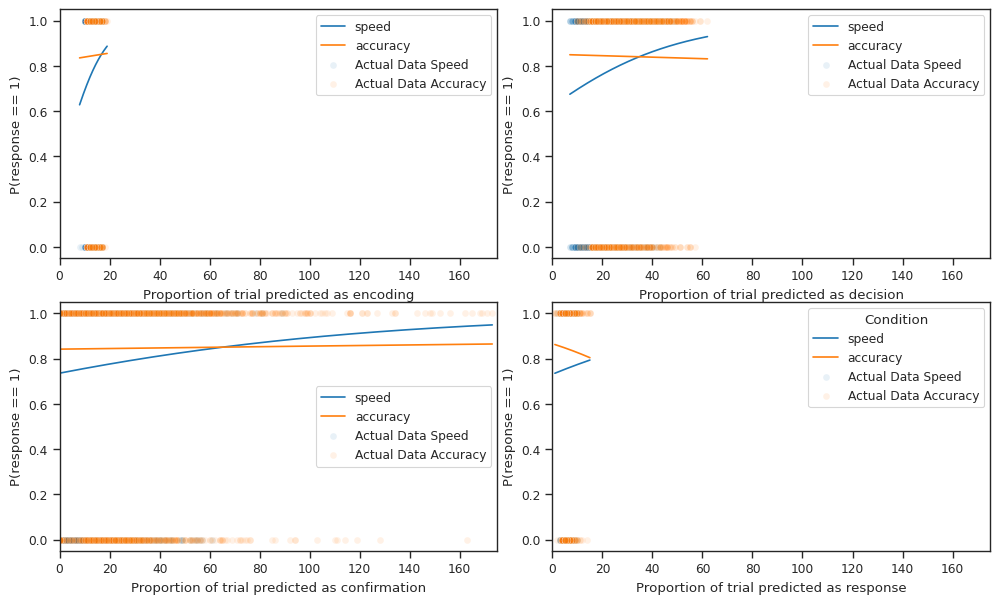

In [16]:
show_lmer(SAT_CLASSES_ACCURACY, data)

### Plot results

#### Knee point

In [7]:
data["ratio"] = (data[f"confirmation_auc"] / 100) / data["rt_x"]
data_sp = data[data['SAT'] == 'speed']
data_acc = data[data['SAT'] == 'accuracy']

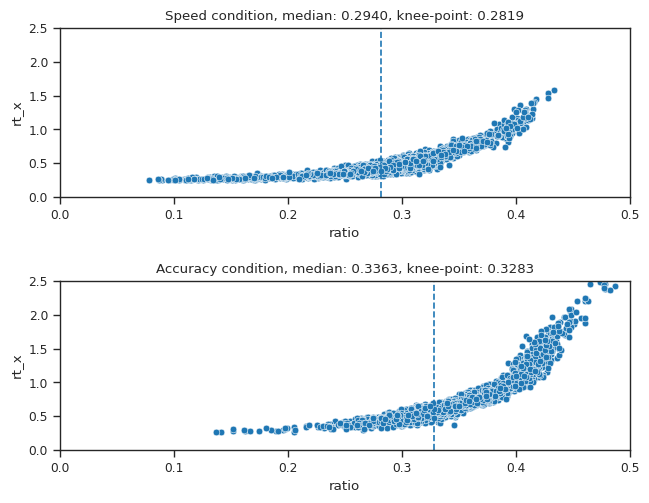

In [78]:
from kneed import KneeLocator
set_seaborn_style()
data["ratio"] = (data[f"confirmation_auc"] / 100) / data["rt_x"]
data_sp = data[data['SAT'] == 'speed']
data_acc = data[data['SAT'] == 'accuracy']
# Fits polynomial and finds knee point using 'Kneedle' algorithm
k_sp = KneeLocator(data_sp['ratio'], data_sp['rt_x'], curve='convex')
k_acc = KneeLocator(data_acc['ratio'], data_acc['rt_x'], curve='convex')

fig, ax = plt.subplots(2, 1)
plt.setp(ax, ylim=(0, 2.5), xlim=(0, 0.5))
plt.tight_layout()
sns.scatterplot(data_sp, x='ratio', y='rt_x', ax=ax[0])
ax[0].axvline(x=k_sp.knee, linestyle='dashed')
ax[0].title.set_text(f"Speed condition, median: {data_sp['ratio'].median():.4f}, knee-point: {k_sp.knee:.4f}")
# plt.title(f"Speed condition, median: {data_sp['ratio'].median():.4f}, knee-point: {k_sp.knee:.4f}")
# plt.figure()
sns.scatterplot(data_acc, x='ratio', y='rt_x', ax=ax[1])
ax[1].axvline(x=k_acc.knee, linestyle='dashed')
ax[1].title.set_text(f"Accuracy condition, median: {data_acc['ratio'].median():.4f}, knee-point: {k_acc.knee:.4f}")
# plt.title(f"Accuracy condition, median: {data_acc['ratio'].median():.4f}, knee-point: {k_acc.knee:.4f}")
plt.subplots_adjust(hspace=0.5) 
plt.plot();

# k_sp.plot_knee()
# print(k_sp.knee)
# print(data_sp['ratio'].median())
# k_acc.plot_knee()
# print(k_acc.knee)
# print(data_acc['ratio'].median())


#### Histogram

<Figure size 640x480 with 0 Axes>

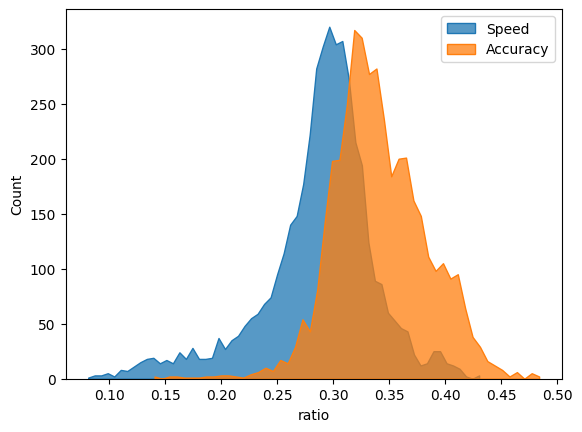

<Figure size 640x480 with 0 Axes>

In [22]:
data["ratio"] = (data[f"confirmation_auc"] / 100) / data["rt_x"]
# data["above_median"] = data["ratio"] >= data["ratio"].median()

sns.histplot(data[data["SAT"] == 'speed'].ratio, element="poly", label="Speed")
sns.histplot(data[data["SAT"] == 'accuracy'].ratio, element="poly", label="Accuracy")
plt.legend()
plt.figure()
# sns.histplot(data[data["above_median"] == True].ratio, element="poly")
# sns.histplot(data[data["above_median"] == False].ratio, element="poly")


In [17]:
data["ratio"] = (data[f"confirmation_auc"] / 100) / data["rt_x"]
IR_cond = data["EMG_sequence"].str.match("..*IR")
CR_cond = data["EMG_sequence"].str.match("..*CR")
data.loc[IR_cond, "wrong"] = True
data.loc[CR_cond, "wrong"] = False
# data[data['EMG_sequence'].str.match("..*IR")]['wrong'] = True
# data[data['EMG_sequence'].str.match("..*CR")]['wrong'] = False

<Axes: xlabel='ratio', ylabel='rt_x'>

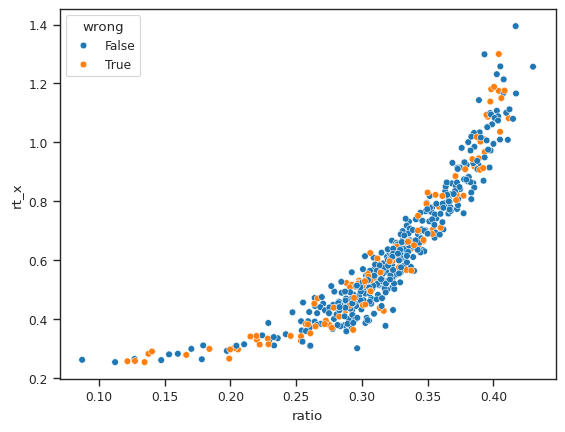

In [18]:
sns.scatterplot(data=data[data["SAT"] == "speed"], x="ratio", y="rt_x", hue="wrong")

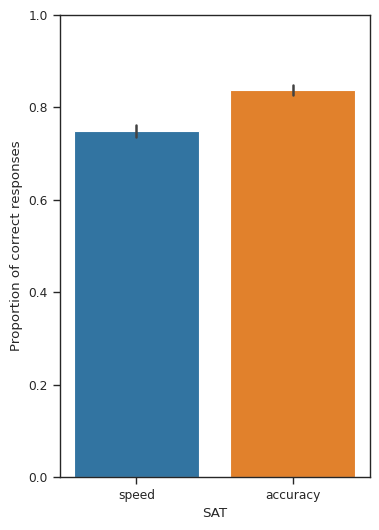

In [19]:
plt.figure(figsize=(4, 6))
sns.barplot(data=data, x='SAT', y='response', hue="SAT")
plt.ylabel("Proportion of correct responses")
plt.ylim(0, 1)
plt.plot();

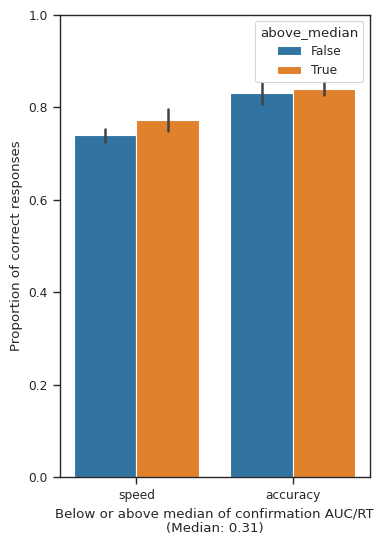

In [20]:
plot_median_split_error_rate(data, "confirmation")

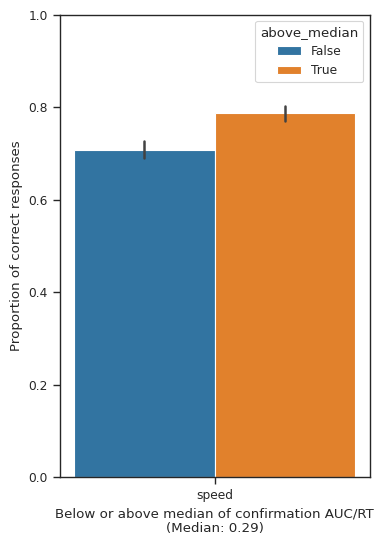

In [10]:
plot_median_split_error_rate(data[data.SAT == "speed"].copy(), "confirmation")

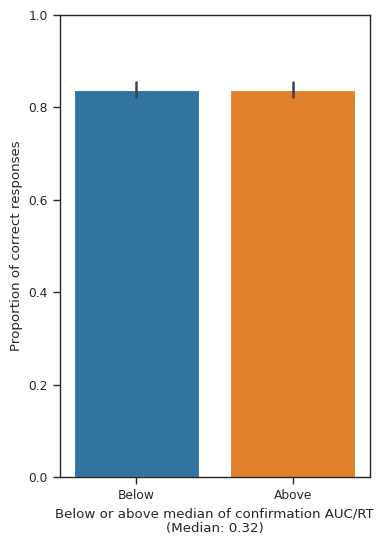

In [27]:
plot_median_split_error_rate(data[data.SAT == "accuracy"].copy(), "confirmation")

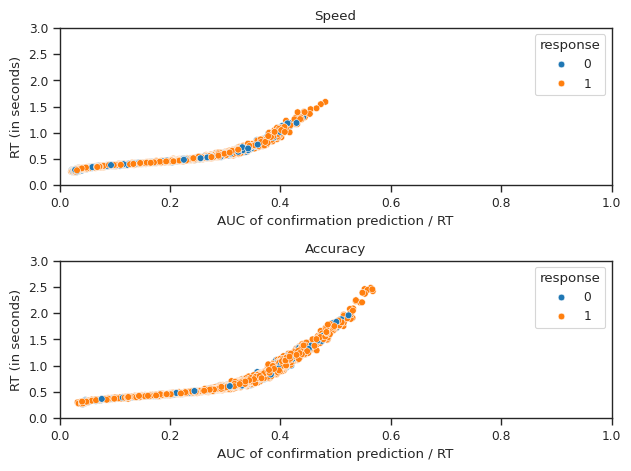

In [38]:
# Confirmation
plt.rcParams["figure.autolayout"] = True
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("tab10")
fig, ax = plt.subplots(2, 1)
ax[0].title.set_text("Speed")
sns.scatterplot(
    data[data["SAT"] == "speed"], x="ratio", y="rt_x", ax=ax[0], hue="response"
)
ax[1].title.set_text("Accuracy")
sns.scatterplot(
    data[data["SAT"] == "accuracy"], x="ratio", y="rt_x", ax=ax[1], hue="response"
)
plt.setp(
    ax,
    xlim=(0, 1.0),
    ylim=(0, 3),
    ylabel="RT (in seconds)",
    xlabel="AUC of confirmation prediction / RT",
)
plt.show()
# Median split of 0.3/knikpunt split, error rate vergelijken

<Axes: xlabel='SAT', ylabel='ratio'>

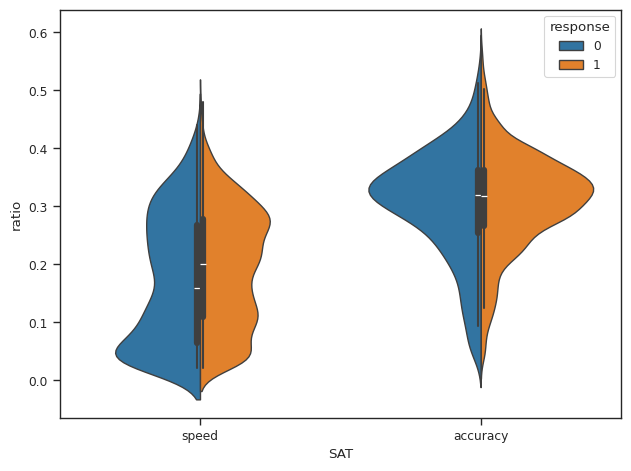

In [31]:
sns.violinplot(x="SAT", y="ratio", data=data, split=True, hue="response")

In [52]:
data

,rt_x,participant,epochs,negative_auc,encoding_auc,decision_auc,confirmation_auc,response_auc,FC,SAT,...,trial,givenResp,response,rt_y,prmt,mt,trialType,EMG_sequence,ratio,ratio_bin
0,0.483398,S6,1897,96.296059,13.305086,18.745558,10.203855,6.449441,1.0,speed,...,1897,right,1,483.398438,423.828125,59.570312,SA,CR,0.133419,"(0.1, 0.2]"
1,0.467773,S11,893,97.005653,13.036636,18.766947,10.374158,5.816609,2.0,speed,...,893,right,1,467.773438,370.117192,97.656245,SA,CR,0.124347,"(0.1, 0.2]"
2,0.318359,S3,122,111.717476,11.747846,13.126358,1.239540,7.168793,2.0,speed,...,122,left,0,318.359375,199.218752,119.140623,SA,IR,0.225179,"(0.2, 0.3]"
3,0.510742,S11,1693,93.085007,13.489601,19.258707,13.254336,5.912354,1.0,speed,...,1693,left,1,510.742188,457.031247,53.710940,SA,CR,0.115760,"(0.1, 0.2]"
4,0.434570,S12,344,100.796234,12.727880,18.139038,7.413616,5.923225,1.0,speed,...,344,left,1,434.570312,401.367185,33.203127,SA,CR,0.136301,"(0.1, 0.2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8504,0.646484,S3,2380,112.191139,14.067734,23.885616,21.095514,6.760001,1.0,accuracy,...,2380,right,1,463.867188,NaN,NaN,UT,R,0.104566,"(0.1, 0.2]"
8505,1.171875,S12,2210,61.566402,16.812986,42.969620,48.813927,7.837066,1.0,accuracy,...,2210,right,1,1171.875000,1134.765630,37.109370,MA,CCCR,0.066876,"(-0.001, 0.1]"
8506,0.916992,S12,1416,85.851532,15.572995,35.144211,34.791965,6.639292,2.0,accuracy,...,1416,right,1,916.992188,784.179690,132.812497,SA,CR,0.072403,"(-0.001, 0.1]"
8507,0.519531,S6,1368,125.193817,13.240362,20.432392,13.610876,5.522545,1.0,accuracy,...,1368,left,1,519.531250,449.218747,70.312503,SA,CR,0.106299,"(0.1, 0.2]"


/workspace/hmp-ai/src/hmpai/visualization.py:833: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(labels=labels, rotation=45)


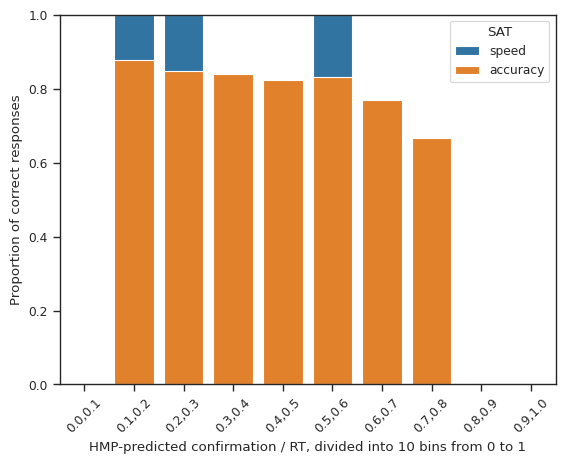

In [13]:
plot_ratio_true_over_RT(data, "confirmation")

/workspace/hmp-ai/src/hmpai/visualization.py:803: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(labels=labels, rotation=45)


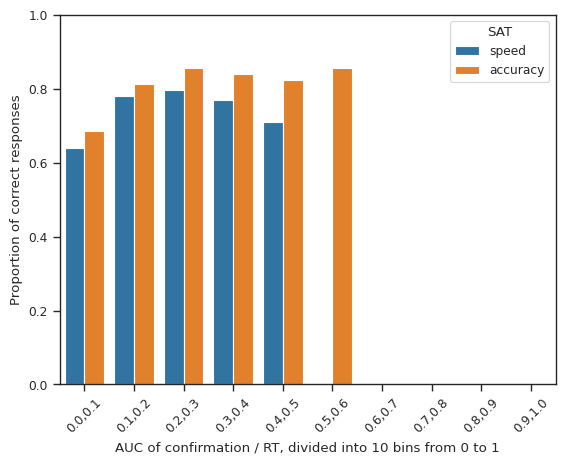

In [14]:
plot_ratio_auc_over_RT(data, "confirmation")

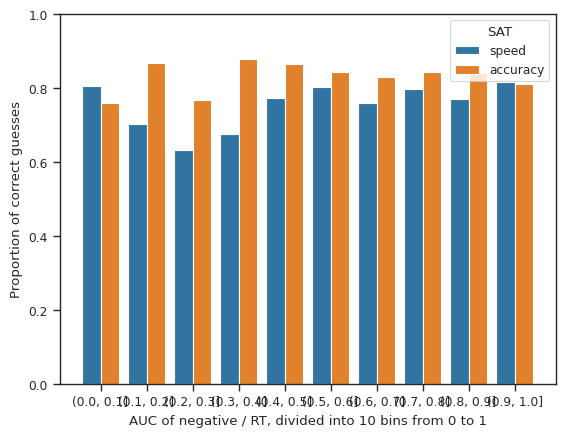

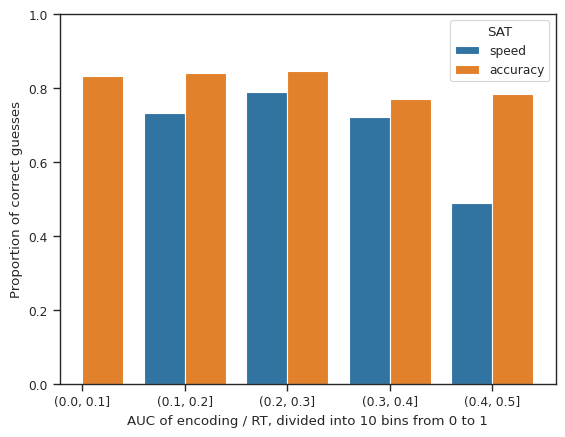

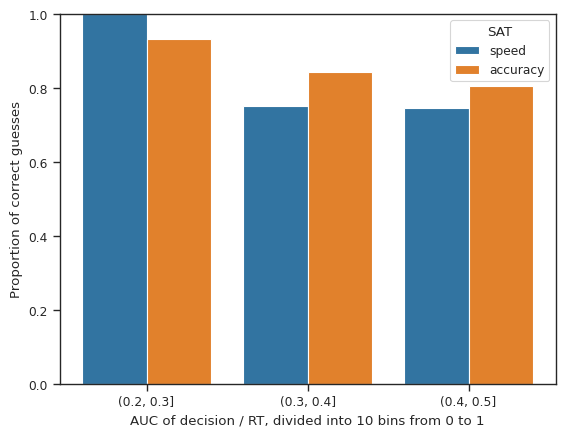

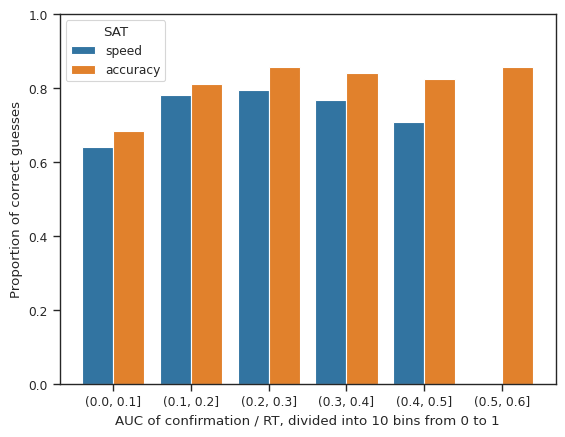

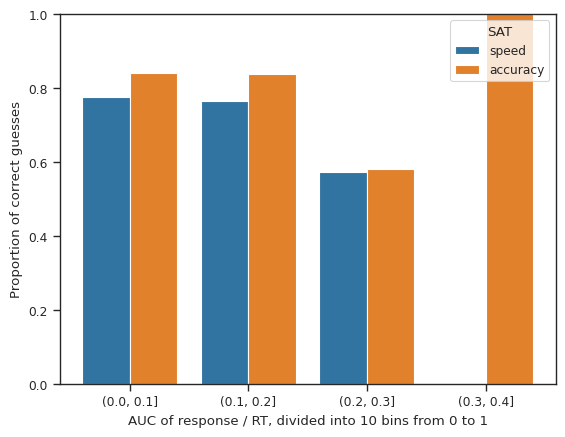

In [29]:
for label in SAT_CLASSES_ACCURACY:
    plot_ratio_auc_over_RT(data, label)